# LeNet

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# load data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485,0.456,0.406],
                                std=[0.229,0.224,0.225])
    ])
trainSet = torchvision.datasets.CIFAR10(root = './data', train=True, 
                                        download = True, transform = transform)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=4,
                                         shuffle=True, num_workers=2)
testSet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True,transform = transform)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'fog', 
          'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np
img = torchvision.utils.make_grid(trainSet[1][0]).numpy()
plt.imshow(np.transpose(img,(1,2,0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 1 Axes>

In [4]:
import torch.nn as nn
class LeNet(nn.Module):
    """
    Input: 3x32x32
    conv1: 5x5kernel          -> 6x1x28x28
    pool1: 2x2kernel stride=2 -> 6x1x14x14
    conv2: 5x5kernel          -> 16x1x10x10
    pool2: 2x2kernel stride=2 -> 16x1x5x5
    conv3: 5x5kernel          -> 120x1x1x1
    fc1:   84
    fc2:   10
    """
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=(5,5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=2),
        nn.Conv2d(6, 16, kernel_size=(5,5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=2),
        nn.Conv2d(16, 120, kernel_size=(5,5)),
        nn.ReLU()
        )
        
        self.fc = nn.Sequential(
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84,10),
        nn.LogSoftmax(dim=-1)
        )
    
    def forward(self, img):
        output = self.conv(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output
            

In [5]:
def evaluate(model, loader):
    correct = 0
    total = len(loader.dataset)
    for x,y in loader:
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        correct += torch.eq(pred,y).sum().float().item()
    return correct/total

In [6]:
import torch.optim as optim
net = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

for epoch in range(10):
    for step,(x,y) in enumerate(trainLoader):
        output = net(x)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    val_acc = evaluate(net, testLoader)
    print("epoch:", epoch,"val_acc:",val_acc)

torch.save(net.state_dict(), 'model.mdl')

epoch: 0 val_acc: 0.5068
epoch: 1 val_acc: 0.5391
epoch: 2 val_acc: 0.5762
epoch: 3 val_acc: 0.5994
epoch: 4 val_acc: 0.6
epoch: 5 val_acc: 0.6093
epoch: 6 val_acc: 0.6159
epoch: 7 val_acc: 0.6041
epoch: 8 val_acc: 0.6059
epoch: 9 val_acc: 0.6188


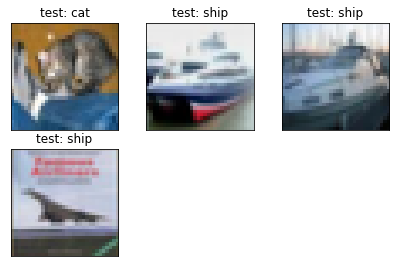

In [7]:
def plot_image(img, label, name):

    fig = plt.figure()
    for i in range(4):
        img[i] = denormalize(img[i])
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(np.transpose(img[i],(1,2,0)), interpolation='none')
        plt.title("{}: {}".format(name, classes[label[i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
def denormalize(x_hat):
        mean=[0.485,0.456,0.406]
        std=[0.229,0.224,0.225]
        
        mean = torch.tensor(mean).unsqueeze(1).unsqueeze(1)
        std = torch.tensor(std).unsqueeze(1).unsqueeze(1)        
        x = x_hat*std+mean
        return x
    
x, y = next(iter(testLoader))
out = net(x)
pred = out.argmax(dim=1).numpy()
plot_image(x, pred, 'test')

In [8]:
print(torch.__version__)

1.2.0
